In [1]:
# hide
# インポート
from sklearn.datasets import make_moons
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.tree import export_graphviz
from PIL import Image
import graphviz
import tempfile

def plt_predict(model, axe, X, title):
    xmin, xmax, ymin, ymax = X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max(), 
    grid = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/300.0), 
                       np.arange(ymin, ymax, (ymax-ymin)/300.0), indexing='xy')
    g = [[x, y] for x, y in zip(np.hstack(grid[0]), np.hstack(grid[1]))]
    p_g = model.predict(g)
    axe.scatter(grid[0], grid[1], c = p_g, cmap=cm.Pastel1, s = 1)
    axe.set_title(title)

def plt_tree(mdl, ax):
    with tempfile.NamedTemporaryFile(mode='w') as f:
        export_graphviz(mdl, out_file=f.name)
        g = graphviz.Source.from_file(f.name)
        with tempfile.NamedTemporaryFile(mode='w', suffix='.png') as f2:
            g.render(outfile=f2.name, format='png')
            im = Image.open(f2.name)
            ax.imshow(im) 
            ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
            ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 

### 2.2.3 決定木とそのバリエーション

#### 2.2.3.1 決定木(Decision Tree)
- Yes/No で答えられる質問で木の形で知識を表現する
- 機械学習としては、このような形の木をデータから自動的に学習する

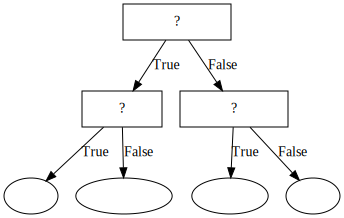

In [2]:
# hide
# 機械学習の分類
import graphviz
dot = graphviz.Digraph('dt', engine='dot')
dot.node('feather', '羽毛があるか?', shape='rectangle')
dot.node('canfly', '飛べるか?', shape='rectangle')
dot.node('hasfin', 'ヒレがあるか?', shape='rectangle')
dot.node('eagle', '鷹')
dot.node('penguin', 'ペンギン')
dot.node('dolphin', 'イルカ')
dot.node('bear', '熊')
dot.edge('feather', 'canfly', label='True')
dot.edge('feather', 'hasfin', label='False')
dot.edge('canfly', 'eagle', label='True')
dot.edge('canfly', 'penguin', label='False')
dot.edge('hasfin', 'dolphin', label='True')
dot.edge('hasfin', 'bear', label='False')
dot

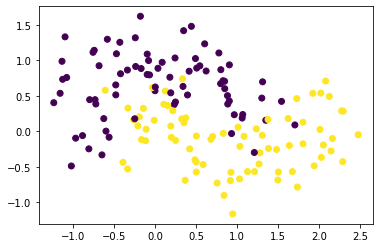

In [3]:
# データの生成と表示
X, y = make_moons(n_samples=200, noise=0.3, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)

In [4]:
# Scikit-learnでの実行
from sklearn.tree import DecisionTreeClassifier

mdl = DecisionTreeClassifier(max_depth=3)
mdl.fit(X_train, y_train)
accuracy_score(mdl.predict(X_train), y_train), \
accuracy_score(mdl.predict(X_test), y_test)

(0.9133333333333333, 0.94)

#### 決定木の動作
- 目標変数を最もよく分離する特徴量と分割点を選び、そこで分割


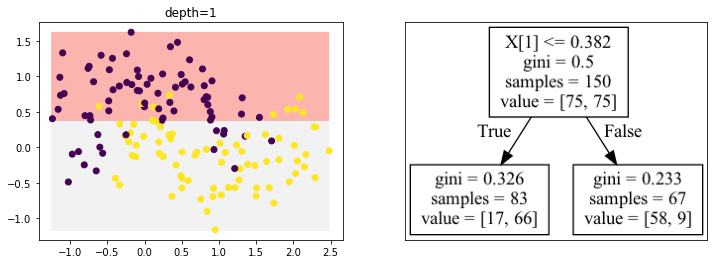

In [5]:
# hide
from sklearn.tree import DecisionTreeClassifier

def plt_dt(X_train, y_train, ax, depth):
    mdl = DecisionTreeClassifier(max_depth=depth)
    mdl.fit(X_train, y_train)
    plt_predict(mdl, ax, X_train, 'depth={}'.format(depth))
    ax.scatter(X_train[:,0], X_train[:,1], c=y_train)
    return mdl

_, axes = plt.subplots(1, 2, figsize=(12,4))
mdl = plt_dt(X_train, y_train, axes[0], 1)
plt_tree(mdl, axes[1])


- 分割されたそれぞれの領域に対して同じことを繰り返す

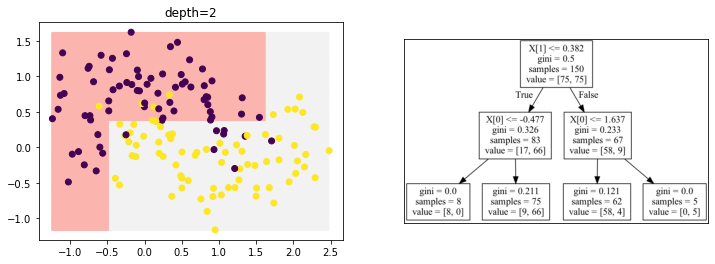

In [6]:
# hide
_, axes = plt.subplots(1, 2, figsize=(12,4))
mdl = plt_dt(X_train, y_train, axes[0], 2)
plt_tree(mdl, axes[1])

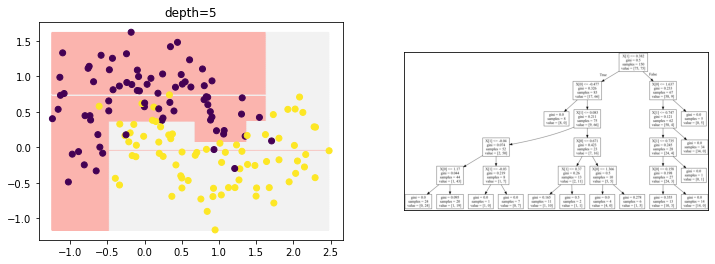

In [7]:
# hide
_, axes = plt.subplots(1, 2, figsize=(12,4))
mdl = plt_dt(X_train, y_train, axes[0], 5)
plt_tree(mdl, axes[1])

**決定木の深さと精度** 

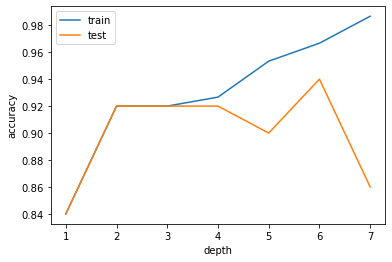

In [8]:
# hide
train_score, test_score = [], []
for d in range(1, 8):
    mdl = DecisionTreeClassifier(max_depth=d)
    mdl.fit(X_train, y_train)
    train_score.append(accuracy_score(mdl.predict(X_train), y_train))
    test_score.append(accuracy_score(mdl.predict(X_test), y_test))
plt.plot(range(1, 8), train_score, label="train")
plt.plot(range(1, 8), test_score, label="test") 
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.legend()
None

- 深さを増やしていくと訓練精度は向上するが、テスト精度は低下する
- 典型的な過学習
- 単純な決定木は非常に過学習しやすい。

#### RandomForest
- 決定木は深くしないと十分な判別力を持つモデルができない
- しかし、決定木を単純に深くしていくと過学習する

そこで
- 乱数を入れて、複数の浅い決定木を多数作成し、合議で決定する
- 乱数 → Random、たくさんの木 → 森(Forest)

**特徴:**
- テーブル型データに対しては非常に強力
- 基本的に過学習しない - チューニングがほぼ不要
- 前処理が不要
- 複数の木を独立に学習できるので並列化が可能 - 計算量は大きい

In [8]:
from sklearn.ensemble import RandomForestClassifier
mdl = RandomForestClassifier()
mdl.fit(X_train, y_train)
accuracy_score(mdl.predict(X_train), y_train),\
accuracy_score(mdl.predict(X_test), y_test)



(1.0, 0.96)

In [10]:
# 使用されている 決定木の個数
len(mdl.estimators_)

100

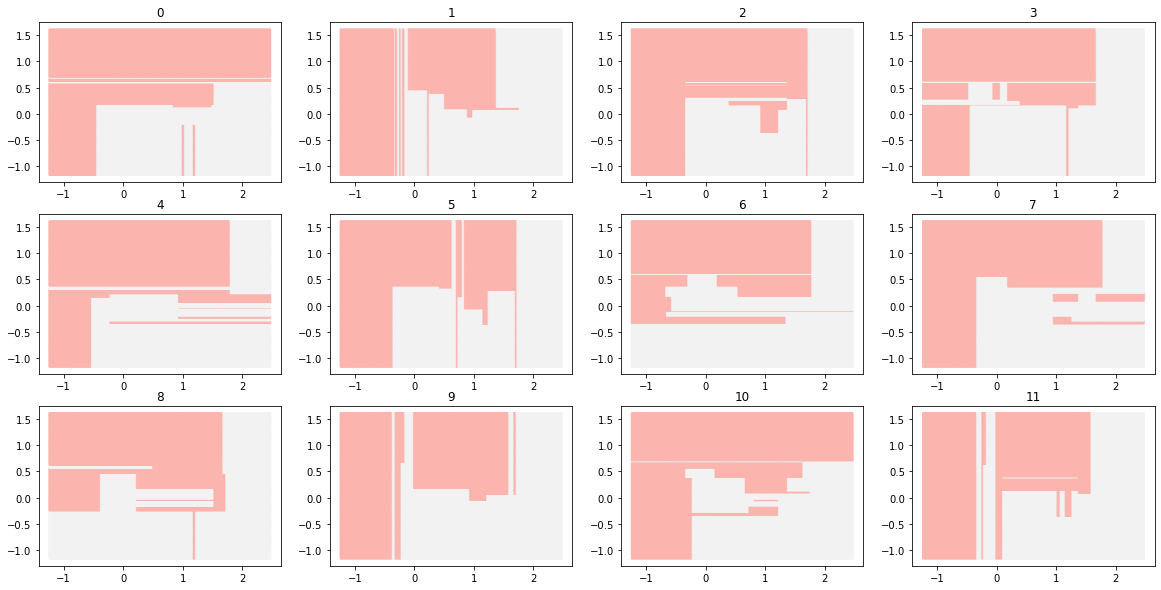

In [11]:
# 最初の24個の決定境界を図示
_, axes = plt.subplots(3, 4, figsize=(20, 10))

for i in range(12):
    plt_predict(mdl.estimators_[i], axes[i//4][i % 4], X, str(i))


それぞれ全く異なる決定木となっていることがわかる。これらを重ね合わせることで汎化した決定境界が得られる。

#### 勾配ブースティング (GradientBoost)

- 多数の決定木を作るという意味では、RandomForestと同じ
- 決定木を並列につくるのではなく、直列的に作る
    1. まず1つ決定木を作る
    2. これまでの決定木の誤りを補正するように決定木を作る
    3. 終了条件を満たすまで2を繰り返す

**特徴**
- パラメータチューニングが必要
- うまくチューニングできるとランダムフォレスとよりも性能がいい    

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
mdl = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
mdl.fit(X_train, y_train)
accuracy_score(mdl.predict(X_train), y_train), \
accuracy_score(mdl.predict(X_test), y_test)

(0.9133333333333333, 0.94)

**学習率と精度**

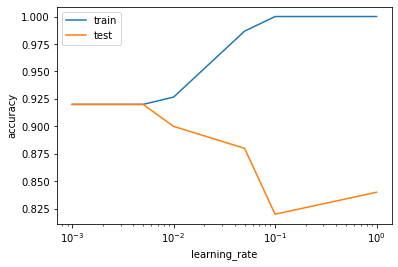

In [13]:
# hide
train_score, test_score = [], []
lrs = [0.001, 0.005, 0.01, 0.05, 0.1, 1]
for lr in lrs:
    mdl = GradientBoostingClassifier(random_state=0, learning_rate=lr)
    mdl.fit(X_train, y_train)
    train_score.append(accuracy_score(mdl.predict(X_train), y_train))
    test_score.append(accuracy_score(mdl.predict(X_test), y_test))

plt.plot(lrs, train_score, label="train")
plt.plot(lrs, test_score, label="test") 
plt.xlabel('learning_rate')
plt.ylabel('accuracy')
plt.xscale('log')
plt.legend()
None

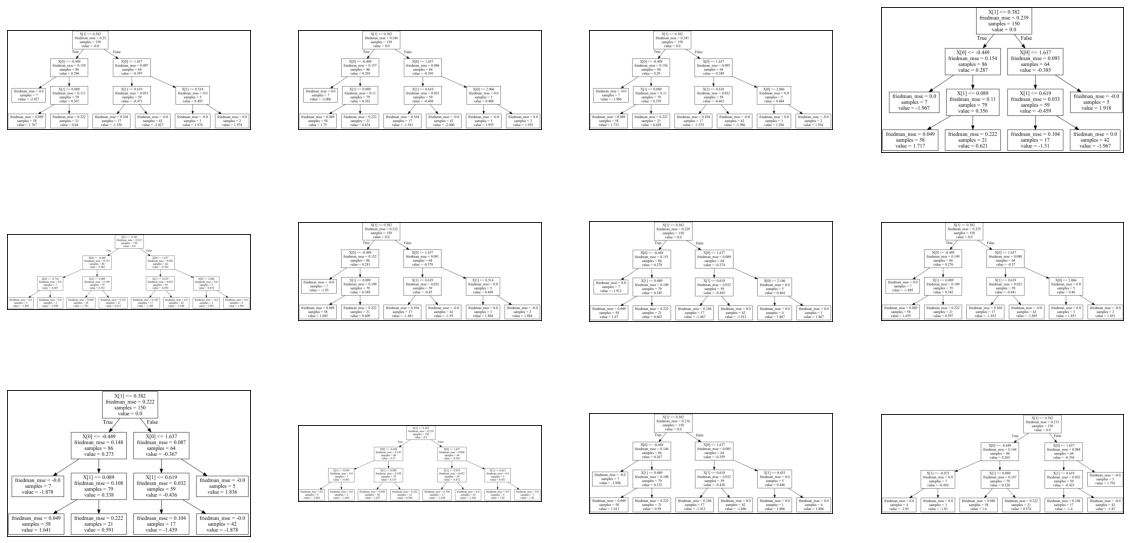

In [14]:
mdl = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
mdl.fit(X_train, y_train)
_, axes = plt.subplots(3, 4, figsize=(20, 10))
for i in range(12):
    plt_tree(mdl.estimators_[i,0], axes[i//4][i % 4])